In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [2]:
import numpy as np
from dare.utils.nodeconstructor import NodeConstructor
import matplotlib.pyplot as plt
import scipy
import control
import copy
import networkx as nx
import random

In [64]:
# define time vector
ts = 1e-4
t_end = 0.1
steps = int(1/ts)
t = np.arange(0, t_end+ts, ts)
num_samples = len(t)

# define values of the parameter
R = 0.4
L = 2.3e-3
C = 10e-6
LT = 2.3e-3
RL = 14

l=1

Rb = l * 0.722
Cb = l * 8*10**-9
Lb = l * 0.955*10**-3

vi1 = 230
vi2 = 230

f0 = 50
V_eff = 230 * np.sqrt(2)

v_sin1 = V_eff * np.sin(2*np.pi * f0 * t)
v_sin2 = V_eff * np.sin(2*np.pi * f0 * t+1)

In [65]:
u = np.array([vi1, vi2])[:,None] * np.ones((2,len(t)))
u_sin = np.array([v_sin1, v_sin2])

In [66]:
#def varaibles

R1 = R
L1 = L
C1 = C
R2 = R
L2 = L
C2 = C
Lb1 = Lb
Lb2 = Lb
Rb1 = Rb
Rb2 = Rb
Cb1 = Cb
Cb2 = Cb

In [67]:
i10 = 0
v10 = 0
iT10 = 0
i20 = 0
v20 = 0
iT20 = 0
url1 = 0 
t0 = 0

# x0 = np.array([i10, v10, iT10, i20, v20, iT20])
x0 = [i10, v10, i20, v20, iT10, iT20, url1]

In [68]:
A_source1 = np.array([[-R1/L1, -1/L1],
                     [1/C, 0]])

A_source2 = np.array([[-R2/L2, -1/L2],
                     [1/C, 0]])

A_zeros = np.zeros((2,2))

A_source = np.block([[A_source1, A_zeros],
                     [A_zeros, A_source2]])

In [69]:
A_col1 = np.array([[0,0,0],
                   [-1/C1, 0,0]])

A_col2 = np.array([[0,0,0],
                   [0, -1/C2, 0]])

A_col = np.block([[A_col1],
                 [A_col2]])

In [70]:
A_row1 = np.array([[0, 1/Lb1],
                  [0, 0],
                  [0, 0]])

A_row2 = np.array([[0, 0],
                  [0, 1/Lb2],
                  [0, 0]])

A_row = np.block([A_row1, A_row2])

In [71]:
A_transitions = np.array([[-Rb1/Lb1, 0, -1/Lb1],
                          [0, -Rb2/Lb2, -1/Lb2],
                          [1/(Cb1+Cb2), 1/(Cb1+Cb2), -1/(RL*(Cb1+Cb2))]])

In [72]:
A_1 = np.block([[A_source, A_col],
              [A_row, A_transitions]])

In [73]:
A_1.shape

(7, 7)

In [74]:
B_source1 = np.array([[1/L1, 0],
                     [0, 0]])
B_source2 = np.array([[0, 1/L2],
                     [0, 0]])

B_transition = np.zeros((3,2))

B_1 = np.block([[B_source1],
              [B_source2],
              [B_transition]])

In [75]:
B_1

array([[434.7826087,   0.       ],
       [  0.       ,   0.       ],
       [  0.       , 434.7826087],
       [  0.       ,   0.       ],
       [  0.       ,   0.       ],
       [  0.       ,   0.       ],
       [  0.       ,   0.       ]])

In [76]:
C_1 = np.eye(7)

In [77]:
D_1 = 0

In [78]:
sys_1 = control.ss(A_1, B_1, C_1, D_1)

In [79]:
T, yout, xout = control.forced_response(sys_1, T=t, U=u_sin, X0=x0, return_x=True, squeeze=True)

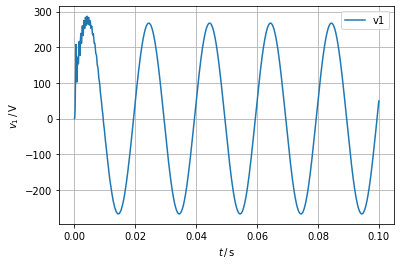

In [80]:
plt.plot(t, xout[1], label='v1')
# plt.plot(t,result[:steps,0], label = 'i1')
plt.xlabel(r'$t\,/\,\mathrm{s}$')
plt.ylabel('$v_{\mathrm{1}}\,/\,\mathrm{V}$')
# plt.title('{}'.format())
plt.legend()
plt.grid()
plt.show()

### Erweiterung NodeConstructor

In [81]:
parameter = dict()
parameter['R_source'] = R
parameter['L_source'] = L
parameter['C_source'] = C
parameter['L_cable'] = Lb
parameter['R_cable'] = Rb
parameter['C_cable'] = Cb
parameter['R_load'] = RL

In [246]:
class NodeConstructor():
    """Node Constructor implementation.

    Helper class for creating a grid structure for scaling purposes. The grid can be defined externally via a so-called CM matrix or randomly generated by the class. The given grid structure is then used to create the ODE equation systems. The output of the equation systems is done via the state space representation with the help of the A, B, C and D matrices. The generated grid can be visualized additionally.

    Attributes:
        num_source: Number of sources in the grid (1,)
        num_loads: Number of loads in the grid (1,)
        tot_ele: Total number of objects in the grid (1,)
        parameter: Dict which includes the parameters of the components 
        S2S_p: Probability that a source is connected to a source (1,)
        S2L_p: Probability that a source is connected to a load (1,)
        num_connections: Number of drawn connections between all objects (1,)
        CM: Connection Matrix specifies which objects are linked to each other via which connection (tot_ele, tot_ele)
        generate_CM: Function that generates CM randomly. A connection to the network is guaranteed, so that no subnets can occur.
        get_sys: Function which outputs the system matrices in the statespace representation
        draw_graph: Function which plots a graph based on the CM
    """
    def __init__(self, num_source, num_loads, parameter, S2S_p=0.1, S2L_p=0.8, CM=None):
        """Creates and initialize a nodeconstructor class instance.

        First the parameters are unpacked and then a CM is created, if not passed.

        Args:
            num_source: Number of sources in the grid (1,)
            num_loads: Number of loads in the grid (1,)
            parameter: Dict which includes the parameters of the components
            S2S_p: Probability that a source is connected to a source (1,)
            S2L_p: Probability that a source is connected to a load (1,)
            CM: Connection Matrix specifies which objects are linked to each other via which connection (tot_ele, tot_ele)
        
        """
        self.num_source = num_source
        self.num_loads = num_loads
        self.tot_ele = num_source + num_loads
        self.S2S_p = S2S_p
        self.S2L_p = S2L_p
        self.cntr = 0
        self.num_connections = 0
        
        # unpack parameters
        self.parameter = parameter
        self.R_source = parameter['R_source']
        self.L_source = parameter['L_source']
        self.C_source = parameter['C_source']
        self.R_cable = parameter['R_cable']
        self.L_cable = parameter['L_cable']
        self.C_cable = parameter['C_cable']
        self.R_load = parameter['R_load']
        
        if isinstance(CM, np.ndarray):
            assert CM.shape[0] == self.tot_ele, "Expect CM to have the same number of elements as tot_ele."
            self.CM = CM
            self.num_connections = int(np.amax(CM))
        elif CM == None:
            self.generate_CM()
        else:
            raise f"Expect CM to be an np.ndarray or None not {type(CM)}."
    
    def tobe_or_n2b(self, x, p):
        """Sets x based on p to zero or to the value of the counter and increments it."""

        # To count up the connection, cntr is returned.
        # If only one type of cable is used this is not necessary an can be replaced by 1
        
        if x < p:
            self.cntr += 1  
            return self.cntr
        else:
            x = 0
            return x
    
    def count_up(self):
        """Increment counter"""

        self.cntr += 1
        return self.cntr
    
    def generate_CM(self):
        """Constructs the CM
        
        Returns the constructed CM and the total number of connections.
        """
        
        # counting the connections 
        self.cntr = 0

        # get a upper triangular matrix
        mask = np.tri(self.tot_ele).T
        CM = np.random.rand(self.tot_ele,self.tot_ele) * mask # fill matrix with random entries between [0,1]
        CM = CM - np.eye(CM.shape[0]) * np.diag(CM) # delet diagonal bc no connection with itself
        
        # go throught the matrix
        # -1 bc last entrie is 0 anyway
        for i in range(self.tot_ele-1):

            # start at i, bc we need to check only upper triangle
            for j in range(i, self.tot_ele-1):
                if j >= self.num_source-1: # select propability according to column
                    CM[i, j+1] = self.tobe_or_n2b(CM[i, j+1], self.S2L_p)
                else:
                    CM[i, j+1] = self.tobe_or_n2b(CM[i, j+1], self.S2S_p)
        
        # make sure that no objects disappear or subnets are formed
        for i in range(self.tot_ele):
            entries = list()
            
            # save rows and columns entries
            Col = CM[:i,i]
            Row = CM[i,i+1:]
            
            # get one list in the form of: [column, row]-entries
            entries.append(CM[:i,i].tolist())
            entries.append(CM[i,i+1:].tolist())
            entries = [item for sublist in entries for item in sublist]

            non_zero = np.sum([entries[i] != 0 for i in range(len(entries))]) # number of non_zero entries
            zero = np.sum([entries[i] == 0 for i in range(len(entries))]) # number of zero entries

            val_to_set = min(2, zero) # minimum of connections is 2
            
            if non_zero <= 2: # we need to set values if there are less then 2 entries
                idx_list = list() # create list to store indexes
                idx_row_entries = np.where(0==Col) # Get rows of the entries = 0
                idx_col_entries = np.where(0==Row) # Get col of the entries = 0

                idx_row_entries = idx_row_entries[0].tolist()
                idx_col_entries = idx_col_entries[0].tolist()

                idx_list.append([(j,i) for _,j in enumerate(idx_row_entries)]) 
                idx_list.append([(i,i+j+1) for _,j in enumerate(idx_col_entries)])
                idx_list = [item for sublist in idx_list for item in sublist]
                
                samples = np.array(val_to_set).clip(0, len(idx_list)) 
                idx_rnd = random.sample(range(0,len(idx_list)), samples) # draw samples from the list
                idx_rnd = np.array(idx_rnd) 
                
                for _, ix in enumerate(idx_rnd):
                    # Based on the random sample, select an indize
                    # from the list and write into the corresponding CM cell.
                    CM[idx_list[ix]] = self.count_up() 
            
        CM = CM - CM.T # copy with negative sign to lower triangle
        
        # save CM
        self.CM = CM
        
        # save number of connections
        self.num_connections = self.cntr
        pass
        
    
    def get_A_source(self, source_x):
        """Create the A_source entry for a source in the A matrix
        
        Returns:
            A_source: Matrix with values belonging to corresponding source (2, 2)
        """
        # this matrix is always a 2x2 for inverter
        A_source = np.zeros((2,2))
        A_source[0,0] = -self.R_source/self.L_source
        A_source[0,1] = -1/self.L_source
        
        
        C_sum =  self.C_source
        
        CM_row = CM[source_x-1]
        indizes = list(CM_row[CM_row != 0])
        
        for _, idx in enumerate(indizes):
            C_sum += self.C_cable # self.C_cable[idx] if diffrent parameters
            
        A_source[1,0] = C_sum**-1
        
        return A_source
    
    def get_B_source(self):
        """Create the B_source entry for a source in the B matrix
        
        Return:
            B_source: Matrix with values belonging to corresponding source (2, 1)
        """
        B_source = np.zeros((2,1))
        B_source[0,0] =  1/self.L_source
        return B_source
    
    def get_A_col(self, source_x):
        """Create the A_col entry in the A matrix

        Return:
            A_col: Matrix with the column entries for A (2, num_connections)
        """

        # for this case self.C_source is assumed to be just an int.
        # Later self.C_source could be an array with the diffrent paramters and would be indexed via self.C_source[source_x]
        
        A_col = np.zeros((2, self.num_connections))

        CM_row = self.CM[source_x-1]

        indizes = list(CM_row[CM_row != 0]) # get entries unequal 0
        signs = np.sign(indizes) # get signs
        indizes_ = indizes*signs # delet signs from indices
        indizes_.astype(dtype=np.int32)


        for i, (idx, sign) in enumerate(zip(indizes_, signs)):
            idx = int(idx)
            C_sum = self.C_source # C[idx] for diffrent values
#             print(f'C_sum:{C_sum}')
#             print(f'Cb:{Cb}')

            for _, jdx in enumerate(indizes):
                C_sum += Cb # self.C_cable[jdx] if diffrent parameters


#             print(f'C_sum:{C_sum}')
#             print(f'C_sum**-1:{C_sum**-1}')
            A_col[1,idx-1] = sign * -(C_sum**-1)
        return A_col
    
    def get_A_row(self, source_x):
        """Create the A_row entry in the A matrix

        Return:
            A_row: Matrix with the row entries for A (num_connections, 2)
        """

        A_row = np.zeros((2, self.num_connections))
        
        CM_col = self.CM[source_x-1]
        
        indizes = list(CM_col[CM_col != 0]) # get entries unequal 0
        
        signs = np.sign(indizes) # get signs
        indizes_ = indizes*signs # delet signs from indices
        
        for i, (idx, sign) in enumerate(zip(indizes_, signs)):
            idx = int(idx)
            A_row[1,idx-1] = sign *1/self.L_cable 
        
        return A_row.T
    
#     def get_A_transitions(self):
#         """Create the A_transitions entry in the A matrix

#         Return:
#             A_transitions: Matrix with column entries for A (num_connections, num_connections)
#         """
#         A_transitions = np.zeros((self.num_connections, self.num_connections))
#         for i in range(1,self.num_connections+1):
#             (row, col) = np.where(self.CM==i)
#             (row_idx, col_idx) = (row[0], col[0])
            
#             # check if its a S2S connection
#             if col_idx < self.num_source: # row_idx < self.num_source and 
                
#                 A_transitions[i-1,i-1] = -self.R_cable/self.L_cable # self.R_cable[i] and self.L_cable[i]
                
#             # Then it has to be S2L
#             else:
#                 # easy diagonal entry
#                 A_transitions[i-1,i-1] = -(self.R_cable + self.R_load)/self.L_cable # (self.R_cable[i] + self.R_load[col_idx])/self.L_cable[i] -> self.R_load[col_idx]? not sure
                
#                 # search for other connections to this specific load in the colum
#                 CM_col = self.CM[:,col_idx]
                
#                 mask = np.logical_and(CM_col > 0, CM_col != i) # i bc we already cover this case
#                 indizes = list(CM_col[mask])
                
#                 # cross entries for the other connections to this load
#                 for j, idx in enumerate(indizes):
#                     idx = int(idx)
#                     A_transitions[i-1, idx-1] = -self.R_load/self.L_cable # self.L_cable[i] if LT is an arry with diffrent values and self.R_load[col_idx]?
        
#         return A_transitions

    def generate_A_tran_diag(self):
        diag = np.eye(self.num_connections)
        vec = np.zeros(self.num_connections)[:, None]
        for i in range(self.num_connections):
            vec[i] = -Rb/Lb #Rb[i]/Lb[i] 
        A_tran_diag = vec*diag
        return A_tran_diag
    
    def generate_A_load_row(self, load_x):
        A_load_row = np.zeros(self.num_connections)

        CM_row = CM[(self.num_source+1)-load_x]

#         print(CM_row)

        indizes = list(CM_row[CM_row != 0]) # get entries unequal 0
        signs = np.sign(indizes) # get signs
        indizes_ = indizes*signs # delet signs from indices
        indizes_.astype(dtype=np.int32)


        for _, (idx, sign) in enumerate(zip(indizes_, signs)):
            idx = int(idx)
            C_sum = 0 # C[idx] for diffrent values
#             print(f'C_sum:{C_sum}')
#             print(f'Cb:{Cb}')

            for _, jdx in enumerate(indizes):
                C_sum += self.C_cable # self.C_cable[jdx] if diffrent parameters


#             print(f'C_sum:{C_sum}')
#             print(f'C_sum**-1:{C_sum**-1}')
            A_load_row[idx-1] = sign * -(C_sum**-1)
        return A_load_row
    
#     def get_A_transition(self):
#         A_tran_diag = generate_A_tran_diag()
#         A_load_col = np.zeros(self.num_loads)
        
#         for i in range(1, self.num_loads+1):
#             A_load_col[i] = generate_A_load_col(i)
        
#         A_load_row = np.zeros(self.num_loads)[:,None]
#         for i in range(1, self.num_loads+1):
#             A_load_row[i] = generate_A_load_row(i)
            
#         A_load_diag = generate_A_load_diag()
        
#         A_transition = np.block([A_tran_diag, A_load_col],
#                                 [A_load_row, A_load_diag])
#         return A_transition
        
    def generate_A_load_col(self, load_x):
        A_load_col = np.zeros(self.num_connections)

        CM_col = CM[(self.num_source+1)-load_x]

        indizes = list(CM_col[CM_col != 0]) # get entries unequal 0

        signs = np.sign(indizes) # get signs
        indizes_ = indizes*signs # delet signs from indices

        for i, (idx, sign) in enumerate(zip(indizes_, signs)):
            idx = int(idx)
            A_load_col[idx-1] = sign *1/Lb
            
        return A_load_col
    
    def generate_A_load_diag(self):
        diag = np.eye(self.num_loads)

        vec = np.zeros(self.num_loads)
        
        print(vec.shape)


        for i in range(self.num_loads):
            print(i)
            CM_row = CM[(self.num_source)+i]
#             print(CM_row)
            indizes = list(CM_row[CM_row != 0])
#             print(indizes)
            C_sum = 0
            for _, (idx, sign) in enumerate(zip(indizes_, signs)):
#                 print(idx)
                idx = int(idx)
                C_sum += self.C_cable  # Cb[idx]

            vec[i] = - (self.R_load * (C_sum))**-1 # Rload[i]

        A_load_diag = vec*diag
        
        return A_load_diag

    
    def generate_A(self):
        """Generate the A matrix
        
        The previously constructed matrices are now plugged together in the form:

            [[A_source, A_col, 0],
            [A_row, A_load_diag, A_load_col],
            [0, A_load_row, A_load_diag]]

        Returns:
            A: A matrix for state space ((2*num_source+num_connections),(2*num_source+num_connections))
        """
        # get A_source
        A_source = np.zeros((2*self.num_source,2*self.num_source)) # construct matrix of zeros
        A_source_list = [self.get_A_source(i) for i in range(1,self.num_source+1)]
                
        for i, ele in enumerate(A_source_list):
            start = 2*i
            stop = 2*i+2
            A_source[start:stop,start:stop] = ele
        
        # get A_col
        A_col = np.zeros((2*self.num_source, self.num_connections))
        A_col_list = [self.get_A_col(i) for i in range(1,self.num_source+1)] # start at 1 bc Source 1 ...
        
        for i, ele in enumerate(A_col_list):
            start = 2*i
            stop = 2*i+2
            A_col[start:stop,:] = ele
        
        # get A_row
        A_row = np.zeros((self.num_connections, 2*self.num_source))
        A_row_list = [self.get_A_row(i) for i in range(1,self.num_source+1)] # start at 1 bc Source 1 ...
        
        for i, ele in enumerate(A_row_list):
            start = 2*i
            stop = 2*i+2
            A_row[:,start:stop] = ele
            
#         A_transitions = self.get_A_transitions()

        A_tran_diag = self.generate_A_tran_diag()
    
        
        A_load_col_list = list()
        for i in range(self.num_loads):
            A_load_col_list.append(self.generate_A_load_col(i+1))
        A_load_col = np.vstack(A_load_col_list).transpose() # i-> idx // i+1 -> num of load
        
        print(A_load_col)
        print(A_load_col.shape)
        
        A_load_row_list = list()
        for i in range(self.num_loads):
            A_load_row_list.append(self.generate_A_load_row(i+1))
        A_load_row = np.vstack(A_load_row_list)
        
        print(A_load_row)
        print(A_load_row.shape)
        
        A_load_diag = self.generate_A_load_diag()
        
#         A_transition = np.block([A_tran_diag, A_load_col],
#                                 [A_load_row, A_load_diag])
        
        A_load_zeros = np.zeros((2*self.num_source, self.num_loads))
        
        A_load_zeros_t = A_load_zeros.transpose()
        
        print(f"A_source.shape: {A_source.shape}")
        print(f"A_col.shape: {A_col.shape}")
        print(f"A_load_zeros.shape: {A_load_zeros.shape}")
        print(f"A_row.shape: {A_row.shape}")
        print(f"A_tran_diag.shape: {A_tran_diag.shape}")
        print(f"A_load_col.shape: {A_load_col.shape}")
        print(f"A_load_zeros_t.shape: {A_load_zeros_t.shape}")
        print(f"A_load_row.shape: {A_load_row.shape}")
        print(f"A_load_diag.shape: {A_load_diag.shape}")
        
        A = np.block([[A_source, A_col, A_load_zeros],
                     [A_row, A_tran_diag, A_load_col],
                     [A_load_zeros_t, A_load_row, A_load_diag]])
        
        return A
    
    def generate_B(self):
        """Generate the B matrix
        
        The previously constructed matrices are now plugged together in the form:

            [[B_source,        0, ...,         0],
             [       0, B_source, ...,         0],
             [       0,        0, ...,         0],
             [       0,        0, ...,  B_source]]

        Returns:
            B: B matrix for state space (2*num_source+num_connections,num_source)

        """
        B = np.zeros((2*self.num_source+self.num_connections,self.num_source))
        
        B_source_list = [self.get_B_source() for i in range(1,self.num_source+1)] # start at 1 bc Source 1 ...
        for i, ele in enumerate(B_source_list):
#             start_c = i
#             stop_c = i+1
            start_r = 2*i
            stop_r = 2*i+2
            B[start_r:stop_r,i:i+1] = ele
        return B
    
    def generate_C(self):
        """Generate the C matrix
        
        Retruns:
            C: Identity matrix (2*num_source+num_connections)
        """
        return np.eye(2*self.num_source+self.num_connections)
    
    def generate_D(self):
        """Generate the D vector
        
        Retruns:
            0: Zero vector (2*num_source+num_connections)
        """
        return 0
    
    def get_sys(self):
        """Returns state space matrices"""

        A = self.generate_A()
        B = self.generate_B()
        C = self.generate_C()
        D = self.generate_D()
        return (A, B, C, D)
    
    def draw_graph(self):
        """Plots a graph according to the CM matrix
        
        Red nodes corresponse to a source.
        Lightblue nodes corresponse to a load.
        """
        
        edges = []
        color = []
        for i in range(1, self.num_connections+1):
            (row, col) = np.where(self.CM==i)
            (row_idx, col_idx) = (row[0]+1, col[0]+1)
            edges.append((row_idx, col_idx))
            if row_idx <= self.num_source:
                color.append('red')
            else:
                color.append('blue')
        
        G = nx.Graph(edges)
        
        color_map = []

        for node in G:
            if node <= self.num_source:
                color_map.append('red')
            else:
                color_map.append('lightblue')

        nx.draw(G, node_color=color_map, with_labels = True)
        plt.show()
        
        pass

In [247]:
Grid_FC = NodeConstructor(2, 1, parameter, S2S_p=1, S2L_p=1)

In [248]:
Grid_FC.get_sys()

[[    0.        ]
 [-1047.12041885]
 [-1047.12041885]]
(3, 1)
[[       0.         62499999.99999999 62499999.99999999]]
(1, 3)
(1,)
0
A_source.shape: (4, 4)
A_col.shape: (4, 3)
A_load_zeros.shape: (4, 1)
A_row.shape: (3, 4)
A_tran_diag.shape: (3, 3)
A_load_col.shape: (3, 1)
A_load_zeros_t.shape: (1, 4)
A_load_row.shape: (1, 3)
A_load_diag.shape: (1, 1)


(array([[-1.73913043e+02, -4.34782609e+02,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 9.98402556e+04,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -9.98402556e+04, -9.98402556e+04,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00, -1.73913043e+02,
         -4.34782609e+02,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  9.98402556e+04,
          0.00000000e+00,  9.98402556e+04,  0.00000000e+00,
         -9.98402556e+04,  0.00000000e+00],
        [ 0.00000000e+00,  1.04712042e+03,  0.00000000e+00,
         -1.04712042e+03, -7.56020942e+02, -0.00000000e+00,
         -0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.04712042e+03,  0.00000000e+00,
          0.00000000e+00, -0.00000000e+00, -7.56020942e+02,
         -0.00000000e+00, -1.04712042e+03],
        [ 0.0000

array([[ -173.91304348,  -434.7826087 ],
       [99840.25559105,     0.        ]])

In [22]:
num_connections = 3

In [188]:
X = np.ones((3,1))

In [189]:
Y= np.zeros((3,1))

In [212]:
np.arange(3)*np.eye(3)

array([[0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 2.]])

In [23]:
CM = np.array([[0,1,2],
              [-1,0,3],
              [-2,-3,0]])

In [24]:
CM

array([[ 0,  1,  2],
       [-1,  0,  3],
       [-2, -3,  0]])

In [45]:
source_x=1

In [46]:
CM_row = CM[source_x-1]

In [39]:
list(CM_row[CM_row != 0])

[-1, 3]

In [41]:
diag

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
diag = np.eye(num_connections)
vec = np.zeros(num_connections)[:, None]
for i in range(num_connections):
    vec[i] = -Rb/Lb #Rb[i]/Lb[i] 
A_tran_diag = vec*diag

In [129]:
A_tran_diag.shape

(3, 1)

In [86]:
num_source = 2

In [96]:
num_loads = 1

In [97]:
load_x = 1

In [ ]:
A_load_row = np.zeros(self.num_connections)

CM_row = CM[(self.num_source+1)-load_x]

print(CM_row)

indizes = list(CM_row[CM_row != 0]) # get entries unequal 0
signs = np.sign(indizes) # get signs
indizes_ = indizes*signs # delet signs from indices
indizes_.astype(dtype=np.int32)

for _, (idx, sign) in enumerate(zip(indizes_, signs)):
    idx = int(idx)
    C_sum = 0 # C[idx] for diffrent values
    print(f'C_sum:{C_sum}')
    print(f'Cb:{Cb}')

    for _, jdx in enumerate(indizes):
        C_sum += self.C_cable # self.C_cable[jdx] if diffrent parameters


    print(f'C_sum:{C_sum}')
    print(f'C_sum**-1:{C_sum**-1}')
    A_load_row[idx-1] = sign * -(C_sum**-1)

In [114]:
A_load_row = np.zeros(num_connections)

CM_col = CM[(num_source+1)-load_x]

print(CM_col)

indizes = list(CM_col[CM_col != 0]) # get entries unequal 0

signs = np.sign(indizes) # get signs
indizes_ = indizes*signs # delet signs from indices

for i, (idx, sign) in enumerate(zip(indizes_, signs)):
    print(idx)
    idx = int(idx)
    A_load_row[idx-1] = sign *1/Lb 

    

[-2 -3  0]
2
3


In [108]:
A_load_row

array([    0.        , -1047.12041885, -1047.12041885])

In [125]:
diag = np.eye(num_loads)

vec = np.zeros(num_loads)[:, None]



print(CM_row)

for i in range(num_loads):
    CM_row = CM[(num_source+1)-load_x]
    indizes = list(CM_row[CM_row != 0])
    print(indizes)
    C_sum = 0
    for _, (idx, sign) in enumerate(zip(indizes_, signs)):
        print(idx)
        idx = int(idx)
        C_sum += Cb  # Cb[idx]
    
    vec[i] = - (RL * (C_sum))**-1

A_load_diag = vec*diag

[-2 -3  0]
[-2, -3]
2
3


In [130]:
A_load_diag.shape

()

In [142]:
A = np.zeros((3,3)).squeeze()
B = np.zeros((3,1)).squeeze()
C = np.zeros((3,1)).squeeze()
D = 1

In [143]:
np.block([[A, B],
        [C, D]])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 3 and the array at index 1 has size 1